In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import robotdatapy as rdp # 1.0.3

# scipy rotation matrix
import scipy as sp

In [2]:
# plt.style.use('/home/masonbp/computer/python/matplotlib/publication.mplstyle')
SAVE = True
QUICK = False
ADD_ANNOTATIONS = True

# quicker
if QUICK:
    num_pcs = 100
    num_markers = 500
else:
    num_pcs = 1000
    num_markers = 3000


In [3]:
def get_pc(bag_path, topic):
    pcd = rdp.data.PointCloudData.from_bag(
        path=bag_path,
        topic=topic,
    )

    marker_data = rdp.data.GeneralData.from_bag(
        path=bag_path,
        topic="/NX01/actual_traj",
        ros_distro='humble',
        time_tol=30.0,
        causal=False
    )

    pc = pcd.pointcloud(pcd.t0).get_xyz()
    pc_frame = pcd.msg_header(pcd.t0).frame_id
    print("pc_frame:", pc_frame)

    pd = rdp.data.PoseData.from_bag_tf(bag_path,
                                    parent_frame="map", child_frame=pc_frame,
                                    time_tol=5.0)

    pc = rdp.transform.transform(pd.pose(pcd.tf), pcd.pointcloud(pcd.tf).get_xyz())
    return pc, pcd, pd, marker_data

def apply_transform(points):
    T_side_view = rdp.transform.xyz_rpy_to_transform([0., 0., 0.], [-80., -0., 0.], degrees=True) @ \
        rdp.transform.xyz_rpy_to_transform([0., 0., 0.,], [0., 0., -30.], degrees=True)
    # T_side_view = np.eye(4)

    # degrees to rotation matrix
    roll = 180
    pitch = 0
    yaw = 0

    rotation_matrix = sp.spatial.transform.Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=True).as_matrix()
    T_world_cam = np.array([
        [1., 0., 0., 60.,],
        [0., -1., 0., 0.,],
        [0., 0., -1., 175.,],
        [0., 0., 0., 1.,]
    ])

    K = np.array([[300, 0., 0.], [0., 300, 0.], [0., 0., 1.]])

    points_cam = rdp.transform.transform(np.linalg.inv(T_world_cam) @ T_side_view, points)
    points_cam = points_cam[points_cam[:,2] > 0.1]
    points_side_view = rdp.camera.xyz_2_pixel(points_cam, K)
    return points_side_view

pc_frame: NX01/NX01_livox
x_min, x_max, y_min, y_max: -9.334899090951907 113.29157249687617 -9.791072758785878 16.859912900312796


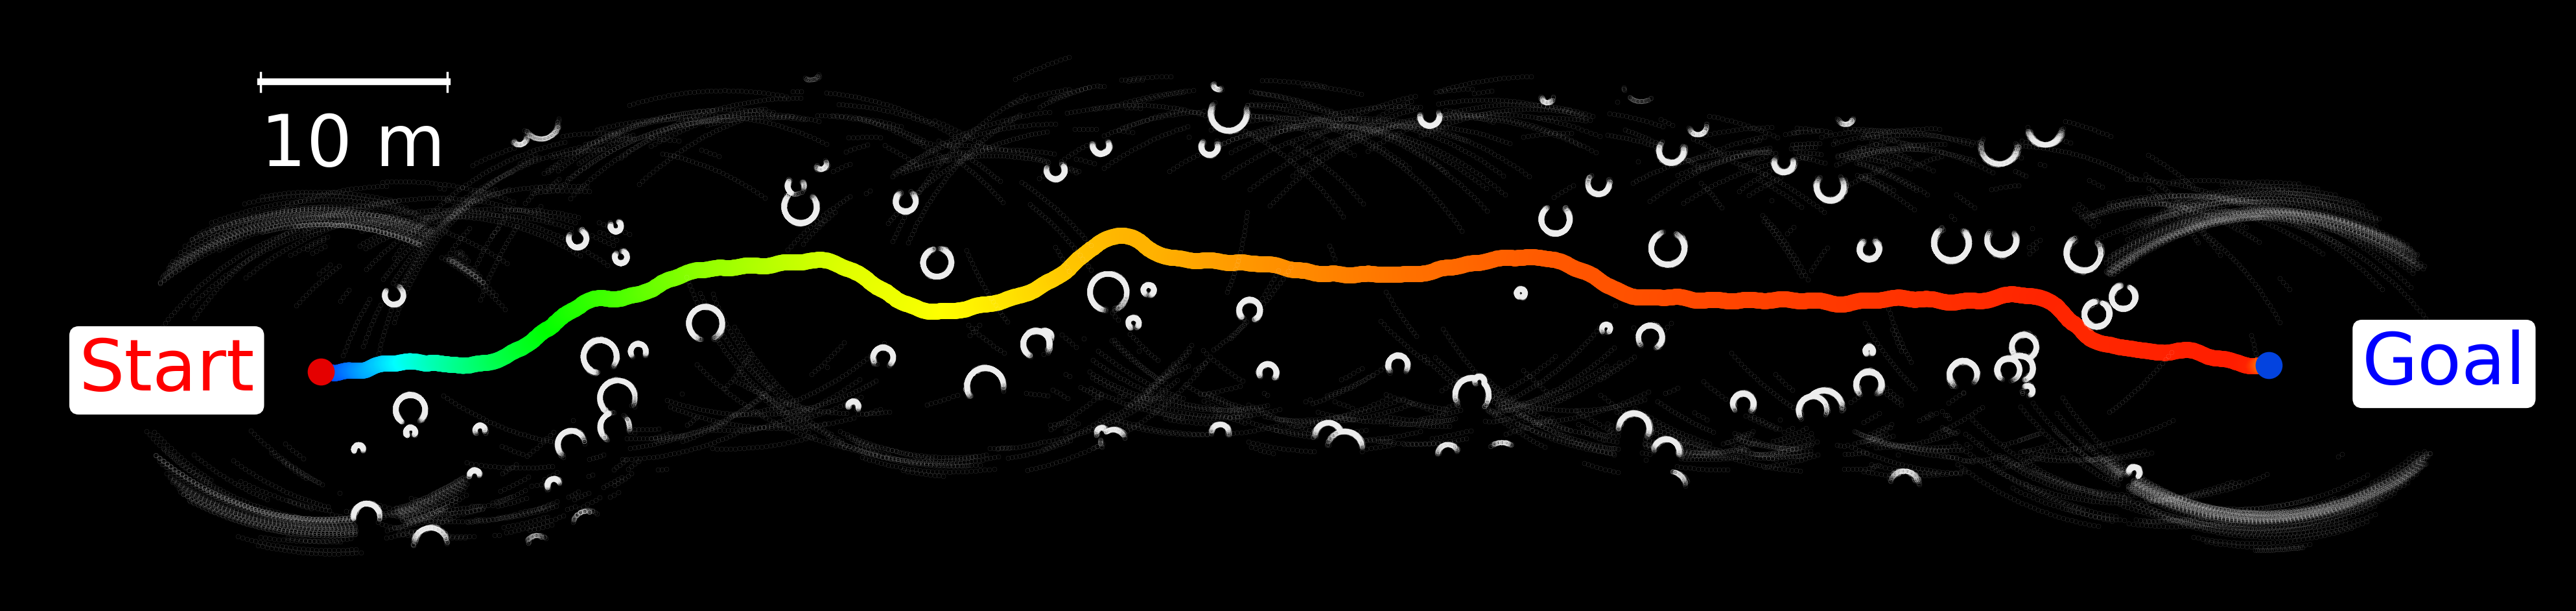

In [13]:
def plot_pc(pc, pcd, pd, marker_data, bag_path, figure_name):
    plt.style.use('dark_background')
    t = np.linspace(pcd.t0, pcd.tf, num_pcs)

    pcs = []
    for ti in t:
        if len(pcd.pointcloud(ti).get_xyz()) == 0:
            continue
        pc = rdp.transform.transform(pd.pose(ti), pcd.pointcloud(ti).get_xyz())
        pcs.append(pc)
        # ax.plot(pc[:,0], pc[:,1], '.', markersize=0.1, alpha=0.2, color='xkcd:aqua')

    pc = np.vstack(pcs)

    marker_xyz = []
    marker_colors = []
    for ti in np.linspace(marker_data.t0, marker_data.tf, num_markers):
        position_ros = marker_data.data(ti).pose.position
        color_ros = marker_data.data(ti).color
        mi = np.array([position_ros.x, position_ros.y, position_ros.z])
        marker_xyz.append(rdp.transform.transform(pd.pose(ti), mi))
        marker_colors.append([color_ros.r, color_ros.g, color_ros.b])
    marker_xyz = np.array(marker_xyz)
    marker_colors = np.array(marker_colors)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10,10), dpi=500)

    # Plot marker data with its corresponding colors
    for i in range(marker_xyz.shape[0]):
        ax.plot(marker_xyz[i,0], marker_xyz[i,1], '.', markersize=5.0, alpha=1.0, color=marker_colors[i])

    # Plot the aggregated point cloud in a light color
    ax.plot(pc[:,0], pc[:,1], '.', markersize=0.15, alpha=0.1, color='xkcd:white')

    # --- Compute and add an accurate 10 m scale bar ---
    # Compute the bounding box of the point cloud data (assumed to be in meters)
    x_min, x_max = np.min(pc[:,0]), np.max(pc[:,0])
    y_min, y_max = np.min(pc[:,1]), np.max(pc[:,1])

    print("x_min, x_max, y_min, y_max:", x_min, x_max, y_min, y_max)

    # Define a padding (5% of axis range) so the scale bar is not flush with the plot edge
    x_pad = 0.05 * (x_max - x_min)
    y_pad = 0.05 * (y_max - y_min)

    # Set the start and end positions for the scale bar in data coordinates
    x_scale_start = x_min + x_pad
    # x_scale_start = marker_xyz[0,0]
    x_scale_end = x_scale_start + 10.0  # 10 meters
    y_scale = y_max - y_pad

    # Draw the horizontal scale bar
    ax.plot([x_scale_start, x_scale_end], [y_scale, y_scale], color='white', linewidth=1.5)
    # Draw vertical ticks at the scale bar endpoints
    ax.plot([x_scale_start, x_scale_start], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
    ax.plot([x_scale_end, x_scale_end], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
    # Label the scale bar
    ax.text(x_scale_start, y_scale - 4.5, '10 m', color='white', fontsize=16)

    # Set equal aspect ratio and turn off axis
    ax.set_aspect('equal')
    ax.axis('off')

    # --- Optional annotations ---
    if ADD_ANNOTATIONS:
        markersize = 10.0
        bbox_props = dict(facecolor='white', boxstyle='round,pad=0.1')
        bbox = bbox=dict(facecolor='white', boxstyle='round,pad=0.1')
        # Plot start and goal markers
        ax.plot([marker_xyz[0,0]], [marker_xyz[0,1]], '.', markersize=markersize, alpha=1.0, color='xkcd:red')
        ax.plot([marker_xyz[-1,0]], [marker_xyz[-1,1]], '.', markersize=markersize, alpha=1.0, color='xkcd:blue')
        # Label start and goal
        ax.text(marker_xyz[0,0] - 13.0, marker_xyz[0,1] - 1, 'Start', color='red', fontsize=16, bbox=bbox_props)
        ax.text(marker_xyz[-1,0] + 5.0, marker_xyz[-1,1] - 1, 'Goal', color='blue', fontsize=16, bbox=bbox_props)
        # Add vertical climb annotation
        # rect = patches.Rectangle([95, -65], 10, 10, edgecolor='xkcd:bright green', 
        #                      facecolor='none', linewidth=2.5, linestyle='--', zorder=2)
        # ax.text(88, -70, 'Vertical Climb', color='xkcd:green', fontsize=16, bbox=bbox)
        # ax.add_patch(rect)

    # Save the figure if required
    if SAVE:
        # folder path is one level up from the bag path
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')

    return pc, marker_xyz, marker_colors

# plot the point cloud data
topic = "/NX01/mid360_PointCloud2"

bag_path = "/media/kkondo/T7/dynus/tro_paper/ground_robot/rosbag2_2025_03_26-22_30_03"
pc, pcd, pd, marker_data = get_pc(bag_path, topic)
pc, marker_xyz, marker_colors = plot_pc(pc, pcd, pd, marker_data, bag_path, "/wheeled_robot_overhead_pc.png")
# plot_with_angle(pc, marker_xyz, marker_colors, bag_path, "/wheeled_robot_side_view_pc.png")

pc_frame: velodyne


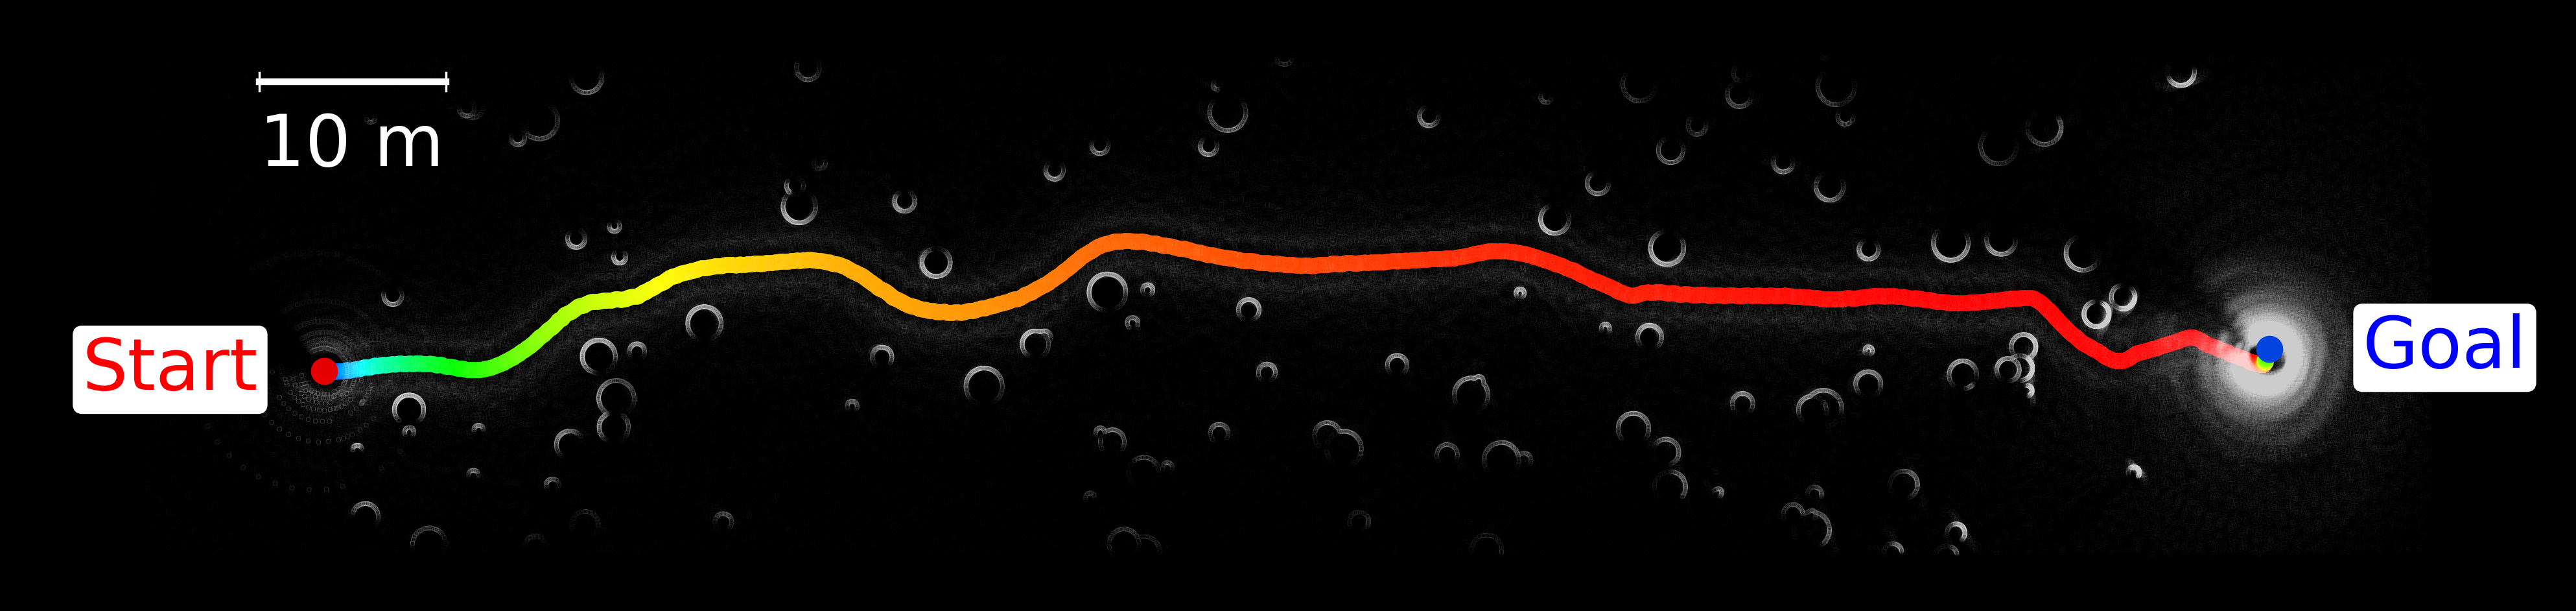

In [31]:
def plot_pc(pc, pcd, pd, marker_data, bag_path, figure_name):


    # I got these from wheeled robot's
    x_min = -9.334899090951907
    x_max = 113.29157249687617
    y_min = -9.791072758785878
    y_max = 16.859912900312796

    plt.style.use('dark_background')
    t = np.linspace(pcd.t0, pcd.tf, num_pcs)

    pcs = []
    for ti in t:
        if len(pcd.pointcloud(ti).get_xyz()) == 0:
            continue
        pc = rdp.transform.transform(pd.pose(ti), pcd.pointcloud(ti).get_xyz())

        pc_tmp = []

        # filter them out 
        for i in range(pc.shape[0]):
            if pc[i,0] < x_min or pc[i,0] > x_max or pc[i,1] < y_min or pc[i,1] > y_max:
                continue
            pc_tmp.append(pc[i])

        # its dense so we sample it
        pc_tmp = np.array(pc_tmp)
        pc_tmp = pc_tmp[::10]
        pc_tmp = pc_tmp.tolist()

        # remove the last 10% of the data
        pc_tmp = pc_tmp[:int(len(pc_tmp) * 0.9)]

        pcs.append(pc_tmp)
        # ax.plot(pc[:,0], pc[:,1], '.', markersize=0.1, alpha=0.2, color='xkcd:aqua')

    pc = np.vstack(pcs)

    marker_xyz = []
    marker_colors = []
    for ti in np.linspace(marker_data.t0, marker_data.tf, num_markers):
        position_ros = marker_data.data(ti).pose.position
        color_ros = marker_data.data(ti).color
        mi = np.array([position_ros.x, position_ros.y, position_ros.z])
        marker_xyz.append(rdp.transform.transform(pd.pose(ti), mi))
        marker_colors.append([color_ros.r, color_ros.g, color_ros.b])
    marker_xyz = np.array(marker_xyz)
    marker_colors = np.array(marker_colors)

    # Create figure and axis
    fig, ax = plt.subplots(figsize=(10,10), dpi=500)

    # Plot marker data with its corresponding colors
    for i in range(marker_xyz.shape[0]):
        ax.plot(marker_xyz[i,0], marker_xyz[i,1], '.', markersize=5.0, alpha=1.0, color=marker_colors[i])

    # Plot the aggregated point cloud in a light color
    ax.plot(pc[:,0], pc[:,1], '.', markersize=0.05, alpha=0.1, color='xkcd:white')

    # --- Compute and add an accurate 10 m scale bar ---
    # Compute the bounding box of the point cloud data (assumed to be in meters)
    # x_min, x_max = np.min(pc[:,0]), np.max(pc[:,0])
    # y_min, y_max = np.min(pc[:,1]), np.max(pc[:,1])

    # Define a padding (5% of axis range) so the scale bar is not flush with the plot edge
    x_pad = 0.05 * (x_max - x_min)
    y_pad = 0.05 * (y_max - y_min)

    # Set the start and end positions for the scale bar in data coordinates
    x_scale_start = x_min + x_pad
    # x_scale_start = marker_xyz[0,0]
    x_scale_end = x_scale_start + 10.0  # 10 meters
    y_scale = y_max - y_pad

    # Draw the horizontal scale bar
    ax.plot([x_scale_start, x_scale_end], [y_scale, y_scale], color='white', linewidth=1.5)
    # Draw vertical ticks at the scale bar endpoints
    ax.plot([x_scale_start, x_scale_start], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
    ax.plot([x_scale_end, x_scale_end], [y_scale - 0.5, y_scale + 0.5], color='white', linewidth=0.5)
    # Label the scale bar
    ax.text(x_scale_start, y_scale - 4.5, '10 m', color='white', fontsize=16)

    # Set equal aspect ratio and turn off axis
    ax.set_aspect('equal')
    ax.axis('off')

    # --- Optional annotations ---
    if ADD_ANNOTATIONS:
        markersize = 10.0
        bbox_props = dict(facecolor='white', boxstyle='round,pad=0.1')
        bbox = bbox=dict(facecolor='white', boxstyle='round,pad=0.1')
        # Plot start and goal markers
        ax.plot([marker_xyz[0,0]], [marker_xyz[0,1]], '.', markersize=markersize, alpha=1.0, color='xkcd:red')
        ax.plot([marker_xyz[-1,0]], [marker_xyz[-1,1]], '.', markersize=markersize, alpha=1.0, color='xkcd:blue')
        # Label start and goal
        ax.text(marker_xyz[0,0] - 13.0, marker_xyz[0,1] - 1, 'Start', color='red', fontsize=16, bbox=bbox_props)
        ax.text(marker_xyz[-1,0] + 5.0, marker_xyz[-1,1] - 1, 'Goal', color='blue', fontsize=16, bbox=bbox_props)
        # Add vertical climb annotation
        # rect = patches.Rectangle([95, -65], 10, 10, edgecolor='xkcd:bright green', 
        #                      facecolor='none', linewidth=2.5, linestyle='--', zorder=2)
        # ax.text(88, -70, 'Vertical Climb', color='xkcd:green', fontsize=16, bbox=bbox)
        # ax.add_patch(rect)

    # Save the figure if required
    if SAVE:
        # folder path is one level up from the bag path
        folder_path = bag_path[:bag_path.rfind('/')]
        plt.savefig(folder_path + figure_name, bbox_inches='tight')

    return pc, marker_xyz, marker_colors

# plot the point cloud data
bag_path = "/media/kkondo/T7/dynus/tro_paper/ground_robot/quadruped/rosbag2_2025_03_27-14_01_40"
topic="/velodyne_points_ros_time"
pc, pcd, pd, marker_data = get_pc(bag_path, topic)
pc, marker_xyz, marker_colors = plot_pc(pc, pcd, pd, marker_data, bag_path, "/quadruped_overhead_pc.png")
# plot_with_angle(pc, marker_xyz, marker_colors, bag_path, "/wheeled_robot_side_view_pc.png")

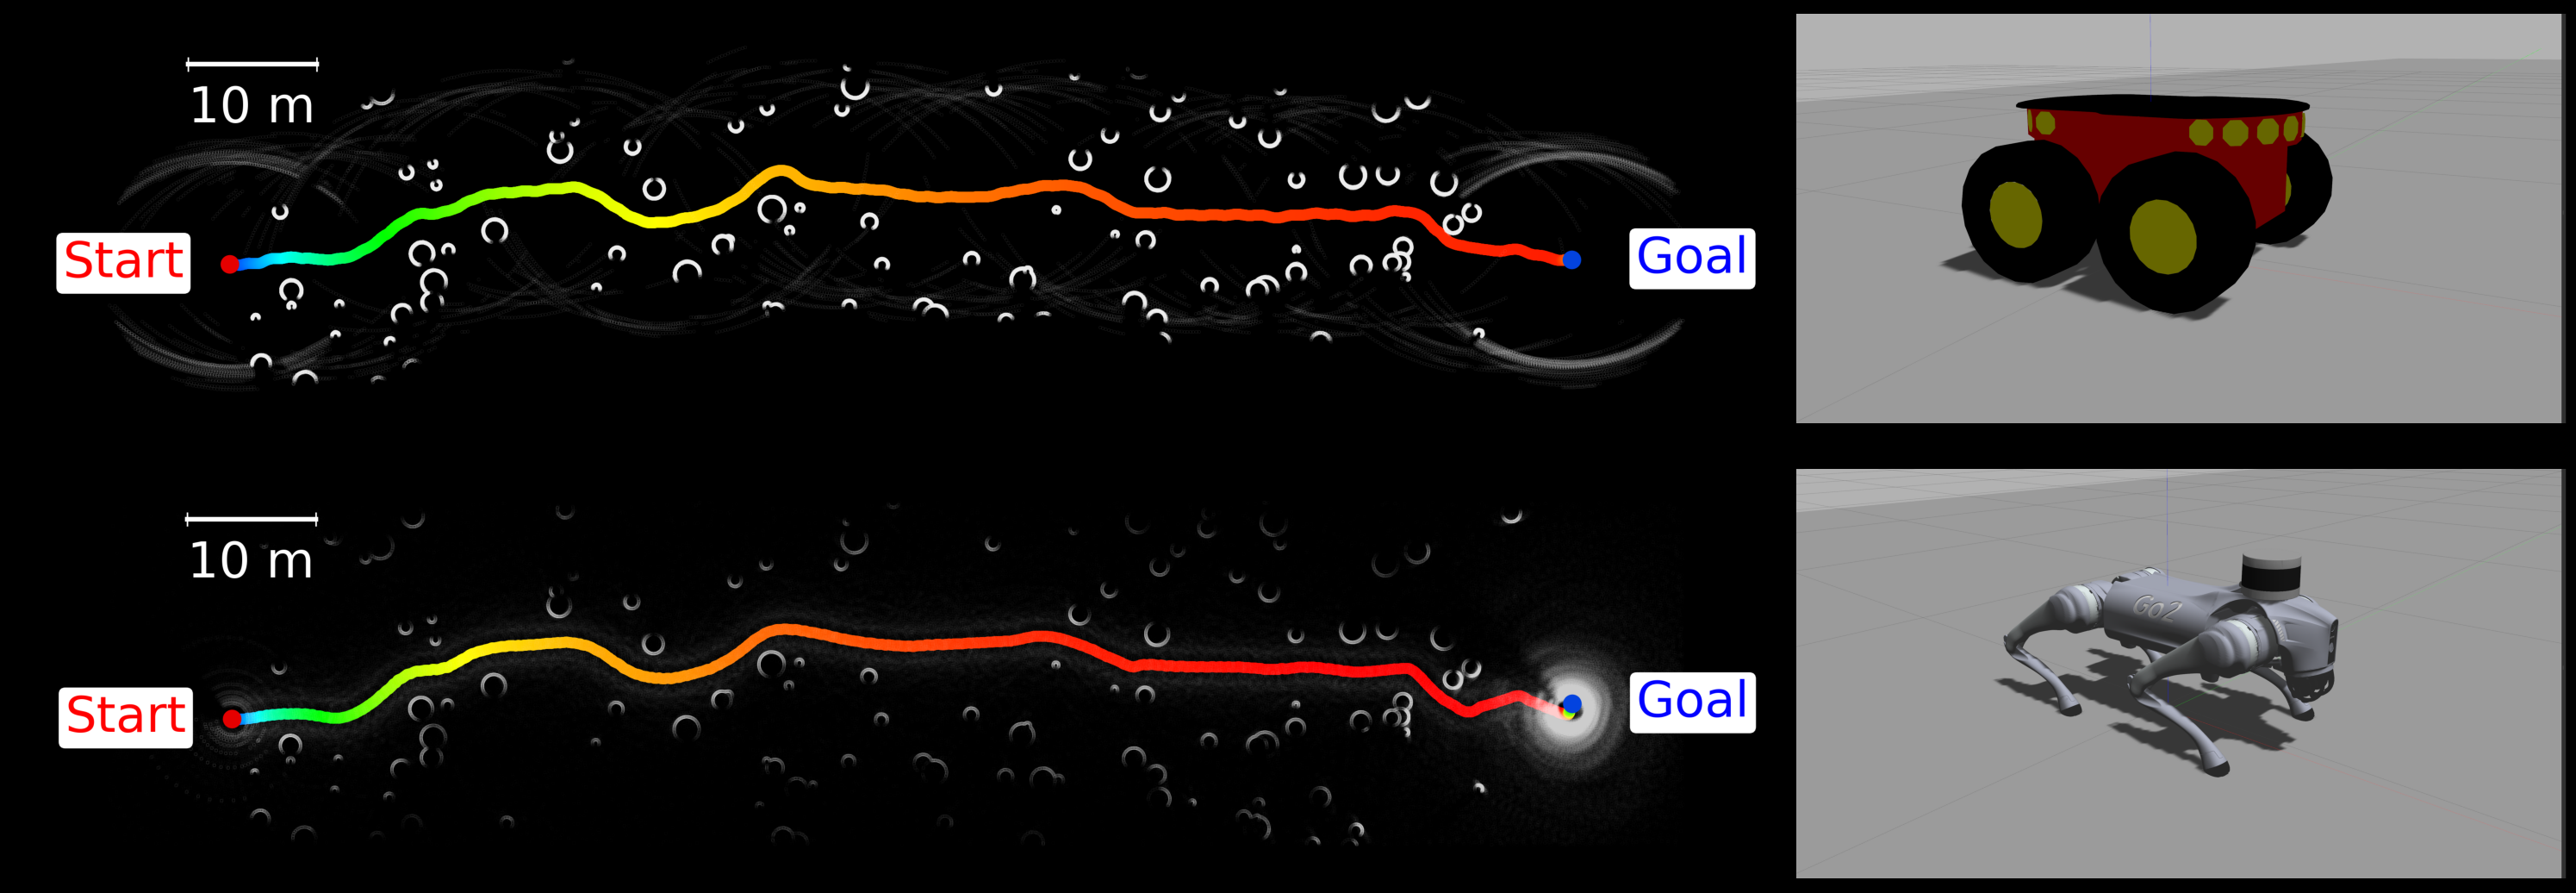

In [39]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load images
folder_path = "/media/kkondo/T7/dynus/tro_paper/ground_robot"
wheeled_image = plt.imread(folder_path + '/wheeled/wheeled_robot_overhead_pc.png')
quadruped_image = plt.imread(folder_path + '/quadruped/quadruped_overhead_pc.png')
wheeled_gazebo_image = plt.imread(folder_path + '/wheeled/wheeled_gazebo.png')
quadruped_gazebo_image = plt.imread(folder_path + '/quadruped/quadruped_gazebo.png')

# Define the cropping region for the gazebo image (adjust as needed)
# Create a figure with GridSpec layout
fig_size_x = 30
fig_size_y = fig_size_x / 2.7  # Golden ratio
fig = plt.figure(figsize=(fig_size_x, fig_size_y))
# Adjust width_ratios to make the right column (gazebo and camera) smaller
gs = gridspec.GridSpec(2, 2, width_ratios=[2.3, 1], height_ratios=[1, 1])

# crop the gazebo images
wheeled_gazebo_image = wheeled_gazebo_image[200:wheeled_gazebo_image.shape[0] - 100, 300:wheeled_gazebo_image.shape[1]]
quadruped_gazebo_image = quadruped_gazebo_image[200:quadruped_gazebo_image.shape[0] - 100, 300:quadruped_gazebo_image.shape[1]]

# Top-left: Overhead image (large)
ax_overhead = fig.add_subplot(gs[0, 0])
ax_overhead.imshow(wheeled_image)
ax_overhead.axis('off')

# Top-right: Gazebo image (smaller)
ax_gazebo = fig.add_subplot(gs[0, 1])
ax_gazebo.imshow(wheeled_gazebo_image)
ax_gazebo.axis('off')

# Bottom-left: Side view image (large)
ax_side_view = fig.add_subplot(gs[1, 0])
ax_side_view.imshow(quadruped_image)
ax_side_view.axis('off')

# Bottom-right: Spotlight image (smaller)
ax_spotlight = fig.add_subplot(gs[1, 1])
ax_spotlight.imshow(quadruped_gazebo_image)
ax_spotlight.axis('off')

plt.tight_layout()
# plt.show()

# save the figure
if SAVE:
    # plt.savefig(folder_path + '/high_res_forest_combined.png', bbox_inches='tight')
    plt.savefig("/media/kkondo/T7/dynus/tro_paper/ground_robot/combined.png", bbox_inches='tight')
    plt.savefig("/home/kkondo/paper_writing/DYNUS_paper/figures/sim/ground_robot/combined.png", bbox_inches='tight')